In [1]:
device = "cpu"
# device = "cuda"
import time,os,copy,torch,torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from tqdm import tqdm
import pickle
# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "16"

In [2]:
random_model = torch.load("./MNIST/random_mnist.h5")

In [3]:
display(random_model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): SpikingActivation(
    (activation): ReLU()
  )
  (2): TemporalAvgPool()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
n_qubits = 6                # Number of qubits
nqubits=n_qubits
q_depth = 2                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01              # Initial spread of random quantum weights
tensor_length = n_qubits*(n_qubits-1)*q_depth+n_qubits

In [5]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RZ_layer(w):
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def entangling_layer(nqubits,weights):
    p = nqubits
    weights_ = (weight for weight in weights)
    for i in range(1,nqubits):
        for j in range(i):
            qml.CNOT(wires=[j,i])
            param = next(weights_)
            # vqc_params.append(param)
            qml.RZ(param, wires=i)
            p+=1
            param = next(weights_)
            # vqc_params.append(param)
            qml.RX(param, wires=i)
            p+=1
            qml.CNOT(wires=[j,i])

In [6]:
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat
    H_layer(n_qubits)
    RZ_layer(q_input_features)
    entangling_layer(nqubits,q_weights)
    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]

    return tuple(exp_vals)
    
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(128, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(tensor_length))
        self.post_net = nn.Linear(n_qubits, 5)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0


        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)



In [10]:
model_hybrid = copy.deepcopy(torch.nn.Sequential(*(list(random_model.children())[:-1])))
for param in model_hybrid.parameters():
    param.requires_grad = False
    
model_hybrid.fc = DressedQuantumNet()

model_hybrid = model_hybrid.to(device)

In [11]:
display(model_hybrid)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): SpikingActivation(
    (activation): ReLU()
  )
  (2): TemporalAvgPool()
  (fc): DressedQuantumNet(
    (pre_net): Linear(in_features=128, out_features=6, bias=True)
    (post_net): Linear(in_features=6, out_features=5, bias=True)
  )
)

In [12]:
class_names = [
    "6",
    "7",
    "8",
    "9",
]
num_classes = len(class_names)

import idx2numpy 
import numpy as np 
arr3 = []
arr4 = []
file1 = './MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte' 
arr = idx2numpy.convert_from_file(file1)
file2 = './MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte' 
arr2 = idx2numpy.convert_from_file(file2)
for i in range(len(arr)):
    if arr2[i] in [6,7,8,9]:
        arr3.append(arr[i])
        arr4.append(arr2[i])

In [13]:
len(arr4)

23983

In [14]:
n_steps = 10
train_images = np.asarray(arr3,dtype=np.float32) / 255.0
train_labels = np.asarray(arr4,dtype=np.int64)

In [15]:
train_labels -= 6
display(train_labels)

array([3, 0, 1, ..., 2, 0, 2])

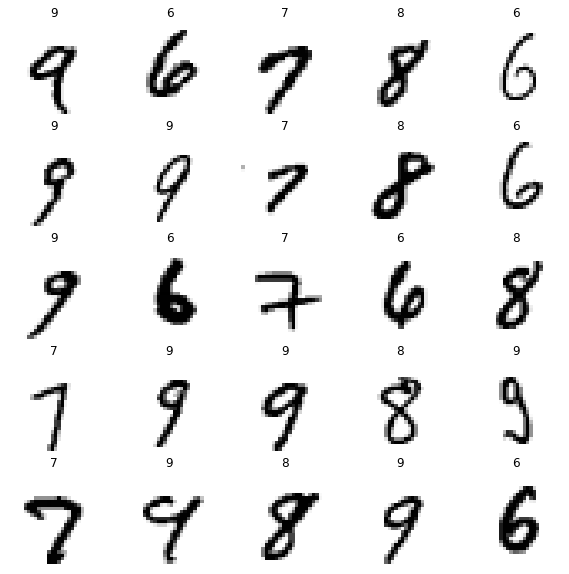

In [16]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

In [17]:
# test_sequences = train_sequences[:int(len(train_sequences)*0.3)]
# test_labels = train_labels[:int(len(train_labels)*0.3)]
# train_sequences = train_sequences[int(len(train_sequences)*0.7):]
# train_labels = train_labels[int(len(train_labels)*0.7):]
split = np.array_split(train_images,[int(len(train_images)*0.7)])
train_sequences = split[0]
test_sequences = split[1]
print(len(split[0]),len(split[1]))
split = np.array_split(train_labels,[int(len(train_labels)*0.7)])
train_labels = split[0]
test_labels = split[1]
print(len(split[0]),len(split[1]))
datalength = 5000

train_sequences = np.tile(train_sequences[:, None], (1, n_steps, 1, 1))[:datalength]
test_sequences = np.tile(test_sequences[:, None], (1, n_steps, 1, 1))
train_labels = train_labels[:datalength]
test_labels = test_labels

print(len(test_labels),len(test_sequences),len(train_labels),len(train_sequences))

16788 7195
16788 7195
7195 7195 5000 5000


In [18]:
metric = []

In [19]:
def train(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adam(input_model.parameters())
 
    input_model.train()
    for j in range(100):
        train_acc = 0
        loss_acc = 0
        for i in tqdm(range(train_x.shape[0] // minibatch_size)):
            input_model.zero_grad()
 
            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_model(torch.tensor(batch_in))
 
            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()
            loss_acc += loss 
 
            loss.backward()
            optimizer.step()
 
            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )
        train_acc /= i + 1  
        print("Train accuracy (%d): " % j, train_acc.numpy())
        #metric_train=train_acc.numpy()

        loss_acc /=i + 1
        print("Loss (%d): " % j, loss_acc.detach().numpy())
        torch.save(model_hybrid,f="./model_saves/4_class_MNIST/6x2_zz_{0}_{1}_{2}.h5".format(j,train_acc.numpy(),loss_acc.detach().numpy()))
 
    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))
         
        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )
 
    test_acc /= i + 1
 
    print("Test accuracy:", test_acc.numpy())

In [20]:
def test(input_model, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adam(input_model.parameters())

    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1

    print("Test accuracy:", test_acc.numpy())

In [28]:
model_hybrid=torch.load("./model_saves/4_class_MNIST/6x2_zz_0_0.5458734035491943_1.3720676898956299.h5")